In [4]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

2026-01-08 16:31:14.593568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767889874.786985      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767889874.841425      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767889875.320462      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767889875.320499      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767889875.320502      55 computation_placer.cc:177] computation placer alr

In [22]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

IMAGE_DIR = "/kaggle/input/flickr8k/Images"
CAPTION_FILE = "/kaggle/input/flickr8k/captions.txt"

BATCH_SIZE = 32
EPOCHS = 10
EMBED_DIM = 512
LR = 1e-4

In [23]:
def load_captions(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        next(f)  # Skip header: image,caption
        
        for line in f:
            line = line.strip()
            if len(line) == 0:
                continue
            
            # Split only on first comma (important!)
            parts = line.split(",", 1)
            
            if len(parts) < 2:
                continue
            
            img_name = parts[0]
            caption = parts[1]
            
            data.append((img_name, caption))
            
    return data

In [25]:
pairs = load_captions(CAPTION_FILE)

pairs = pairs[:25000]        # ✅ limit dataset
print("Total samples used:", len(pairs))

Total samples used: 25000


In [7]:
# pairs = load_captions(CAPTION_FILE)

# print("Total samples:", len(pairs))
# print("First 5 samples:")
# for i in range(5):
#     print(pairs[i])

Total samples: 40455
First 5 samples:
('1000268201_693b08cb0e.jpg', 'A child in a pink dress is climbing up a set of stairs in an entry way .')
('1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .')
('1000268201_693b08cb0e.jpg', 'A little girl climbing into a wooden playhouse .')
('1000268201_693b08cb0e.jpg', 'A little girl climbing the stairs to her playhouse .')
('1000268201_693b08cb0e.jpg', 'A little girl in a pink dress going into a wooden cabin .')


In [26]:
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [27]:
class FlickrDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_name, caption = self.pairs[idx]

        img_path = os.path.join(IMAGE_DIR, img_name)
        image = Image.open(img_path).convert("RGB")
        image = image_transform(image)

        tokens = tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=32,
            return_tensors="pt"
        )

        return image, tokens["input_ids"].squeeze(0), tokens["attention_mask"].squeeze(0)

dataset = FlickrDataset(pairs)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [28]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        base = models.resnet18(pretrained=True)
        base.fc = nn.Identity()
        self.backbone = base
        self.fc = nn.Linear(512, embed_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [30]:
class TextEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, embed_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:,0]
        return self.fc(cls_embedding)

In [31]:
class Predictor(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, embed_dim)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
image_encoder = ImageEncoder(EMBED_DIM).to(DEVICE)
text_encoder  = TextEncoder(EMBED_DIM).to(DEVICE)
predictor     = Predictor(EMBED_DIM).to(DEVICE)
# Freeze BERT parameters
# for param in text_encoder.bert.parameters():
#     param.requires_grad = False


params = list(image_encoder.parameters()) + \
         list(text_encoder.parameters()) + \
         list(predictor.parameters())
# params = list(image_encoder.parameters()) + \
#          list(text_encoder.fc.parameters()) + \
#          list(predictor.parameters())


optimizer = torch.optim.Adam(params, lr=LR)
# criterion = nn.CosineEmbeddingLoss()
import torch.nn.functional as F

def info_nce_loss(z_pred, z_txt, temperature=0.07):
    z_pred = F.normalize(z_pred, dim=1)
    z_txt  = F.normalize(z_txt, dim=1)

    logits = torch.matmul(z_pred, z_txt.T) / temperature
    labels = torch.arange(z_pred.size(0)).to(z_pred.device)

    return F.cross_entropy(logits, labels)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
EPOCHS = 15

In [ ]:
for epoch in range(EPOCHS):
    total_loss = 0
    for images, input_ids, masks in tqdm(loader):
        images = images.to(DEVICE)
        input_ids = input_ids.to(DEVICE)
        masks = masks.to(DEVICE)

        z_img = image_encoder(images)
        z_txt = text_encoder(input_ids, masks)
        z_pred = predictor(z_img)

        #  L2 normalization
        z_txt  = torch.nn.functional.normalize(z_txt, dim=1)
        z_pred = torch.nn.functional.normalize(z_pred, dim=1)


        target = torch.ones(z_img.size(0)).to(DEVICE)
        # loss = criterion(z_pred, z_txt, target)
        loss = info_nce_loss(z_pred, z_txt)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {total_loss:.4f}")

100%|██████████| 782/782 [06:39<00:00,  1.96it/s]


Epoch [1/15] Loss: 769.5632


100%|██████████| 782/782 [06:20<00:00,  2.05it/s]


Epoch [2/15] Loss: 268.5514


100%|██████████| 782/782 [06:15<00:00,  2.08it/s]


Epoch [3/15] Loss: 179.6265


100%|██████████| 782/782 [06:12<00:00,  2.10it/s]


Epoch [4/15] Loss: 148.9520


100%|██████████| 782/782 [06:14<00:00,  2.09it/s]


Epoch [5/15] Loss: 131.5210


100%|██████████| 782/782 [06:16<00:00,  2.08it/s]


Epoch [6/15] Loss: 119.4979


100%|██████████| 782/782 [06:12<00:00,  2.10it/s]


Epoch [7/15] Loss: 107.6482


100%|██████████| 782/782 [06:10<00:00,  2.11it/s]


Epoch [8/15] Loss: 98.3860


100%|██████████| 782/782 [06:11<00:00,  2.11it/s]


Epoch [9/15] Loss: 91.4738


100%|██████████| 782/782 [06:08<00:00,  2.12it/s]


Epoch [10/15] Loss: 92.2830


100%|██████████| 782/782 [06:11<00:00,  2.11it/s]


Epoch [11/15] Loss: 89.4487


100%|██████████| 782/782 [06:11<00:00,  2.11it/s]


Epoch [12/15] Loss: 73.2089


100%|██████████| 782/782 [06:12<00:00,  2.10it/s]


Epoch [13/15] Loss: 75.0707


100%|██████████| 782/782 [06:10<00:00,  2.11it/s]


Epoch [14/15] Loss: 69.7270


100%|██████████| 782/782 [06:10<00:00,  2.11it/s]

Epoch [15/15] Loss: 64.2048


In [35]:
def build_caption_index():
    captions = []
    embeddings = []

    text_encoder.eval()

    with torch.no_grad():
        for img, input_ids, masks in tqdm(loader):
            input_ids = input_ids.to(DEVICE)
            masks = masks.to(DEVICE)

            z = text_encoder(input_ids, masks)
            embeddings.append(z.cpu().numpy())

    embeddings = np.vstack(embeddings)
    return embeddings

caption_embeddings = build_caption_index()

100%|██████████| 782/782 [03:20<00:00,  3.90it/s]


In [36]:
def retrieve_caption(image_path, top_k=5):
    image = Image.open(image_path).convert("RGB")
    image = image_transform(image).unsqueeze(0).to(DEVICE)

    image_encoder.eval()
    predictor.eval()

    with torch.no_grad():
        z_img = image_encoder(image)
        z_pred = predictor(z_img).cpu().numpy()

    sims = cosine_similarity(z_pred, caption_embeddings)[0]
    top_idx = np.argsort(sims)[::-1][:top_k]

    print("\nTop retrieved captions:\n")
    for idx in top_idx:
        print(pairs[idx][1])

# Example 1

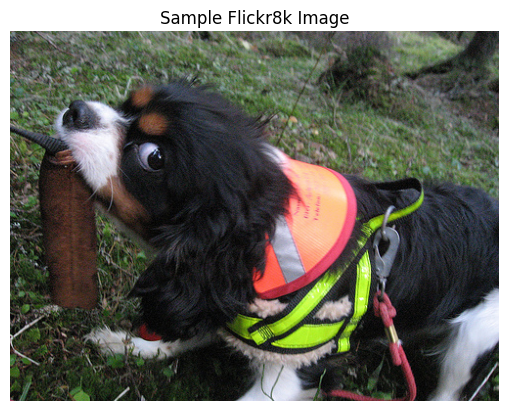

In [45]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/kaggle/input/flickr8k/Images/1827560917_c8d3c5627f.jpg"

img = Image.open(img_path)

plt.imshow(img)
plt.axis("off")
plt.title("Sample Flickr8k Image")
plt.show()

In [46]:
test_image = "/kaggle/input/flickr8k/Images/1827560917_c8d3c5627f.jpg"
retrieve_caption(test_image)


Top retrieved captions:

Men ride on horses while carrying flags .
One biker is running with their bike while another is riding around them .
Many people in warm clothing crowd around carnival games indoors .
A man performs a trick on a surfboard in the water .
A dog and a tennis ball .


# Example 2

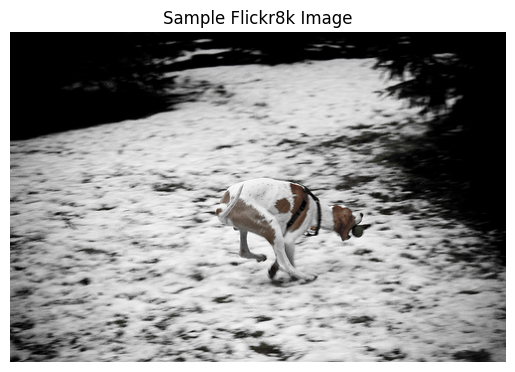

In [49]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg"

img = Image.open(img_path)

plt.imshow(img)
plt.axis("off")
plt.title("Sample Flickr8k Image")
plt.show()

In [38]:
test_image = "/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg"
retrieve_caption(test_image)


Top retrieved captions:

A young boy is getting ready to hit a baseball .
A man in black shorts is stretching out his leg .
Two dogs are running down a dirt path in a grassy field .
Two young women walk past a door in a white wall .
A person in blue and red ice climbing with two picks .


# Example 3

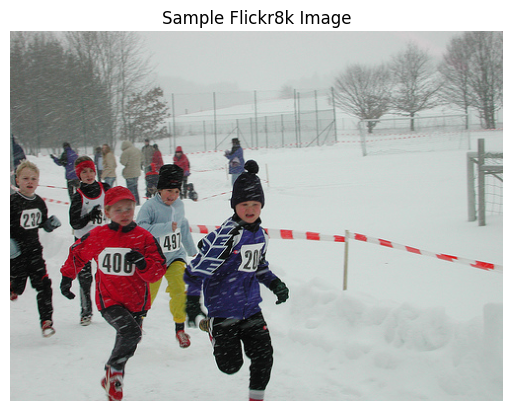

In [48]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/kaggle/input/flickr8k/Images/72218201_e0e9c7d65b.jpg"

img = Image.open(img_path)

plt.imshow(img)
plt.axis("off")
plt.title("Sample Flickr8k Image")
plt.show()

In [47]:
test_image = "/kaggle/input/flickr8k/Images/72218201_e0e9c7d65b.jpg"
retrieve_caption(test_image)


Top retrieved captions:

The black and white dog has its mouth wide open .
Two kids are bouncing on colorful balls .
a black and white dog running through some red and white poles
A large rock formation in the middle of a forest .
A woman with a purple feather decoration in her hair and wearing caution tape


In [39]:
import numpy as np
import torch
from tqdm import tqdm

def collect_embeddings(loader):
    image_encoder.eval()
    predictor.eval()
    text_encoder.eval()

    Z_img = []
    Z_pred = []
    Z_txt = []

    with torch.no_grad():
        for images, input_ids, masks in tqdm(loader):
            images = images.to(DEVICE)
            input_ids = input_ids.to(DEVICE)
            masks = masks.to(DEVICE)

            z_img = image_encoder(images)
            z_txt = text_encoder(input_ids, masks)
            z_pred = predictor(z_img)

            Z_img.append(z_img.cpu().numpy())
            Z_txt.append(z_txt.cpu().numpy())
            Z_pred.append(z_pred.cpu().numpy())

    return (
        np.vstack(Z_img),
        np.vstack(Z_pred),
        np.vstack(Z_txt)
    )

Z_img, Z_pred, Z_txt = collect_embeddings(loader)
print("Embedding shapes:", Z_pred.shape, Z_txt.shape)

100%|██████████| 782/782 [03:30<00:00,  3.72it/s]

Embedding shapes: (25000, 512) (25000, 512)


Mean similarity: 0.79203385
Std similarity: 0.076580875


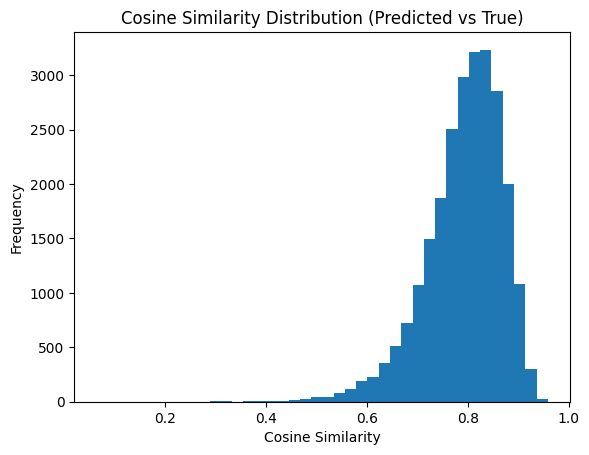

In [40]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# similarity for correct pairs
similarities = np.array([
    cosine_similarity(Z_pred[i].reshape(1,-1),
                      Z_txt[i].reshape(1,-1))[0][0]
    for i in range(len(Z_pred))
])

print("Mean similarity:", similarities.mean())
print("Std similarity:", similarities.std())

plt.figure()
plt.hist(similarities, bins=40)
plt.title("Cosine Similarity Distribution (Predicted vs True)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

Recall@1: 0.127
Recall@3: 0.329
Recall@5: 0.469
Recall@10: 0.636


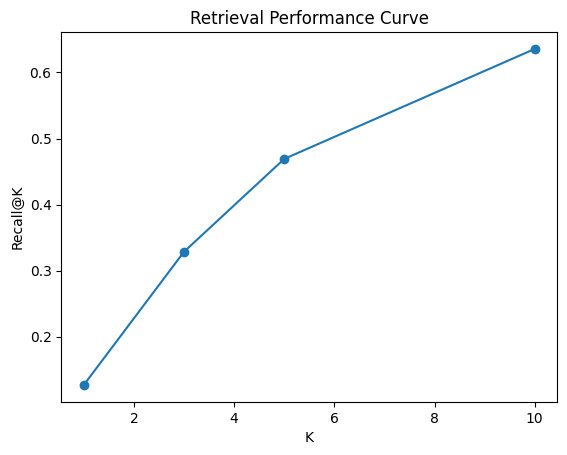

In [41]:
def recall_at_k(Z_pred, Z_txt, K=5):
    sims = cosine_similarity(Z_pred, Z_txt)
    correct = 0

    for i in range(len(Z_pred)):
        top_k = np.argsort(sims[i])[::-1][:K]
        if i in top_k:
            correct += 1

    return correct / len(Z_pred)

Ks = [1, 3, 5, 10]
recalls = [recall_at_k(Z_pred, Z_txt, k) for k in Ks]

for k, r in zip(Ks, recalls):
    print(f"Recall@{k}: {r:.3f}")

plt.figure()
plt.plot(Ks, recalls, marker="o")
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Retrieval Performance Curve")
plt.show()

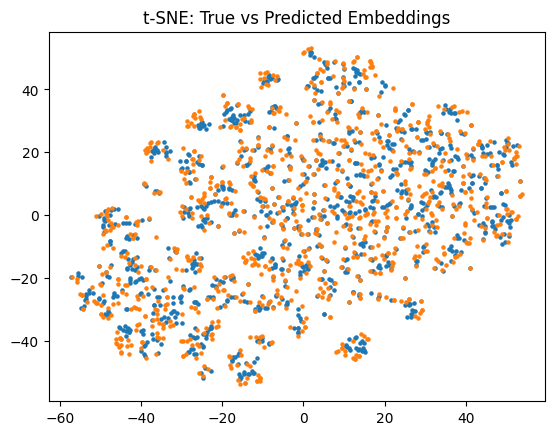

In [42]:
from sklearn.manifold import TSNE

# Use only first 1000 samples for speed
N = 1000
Z_vis = np.vstack([Z_txt[:N], Z_pred[:N]])
labels = np.array([0]*N + [1]*N)  # 0=true, 1=pred

tsne = TSNE(n_components=2, perplexity=30)
Z_2d = tsne.fit_transform(Z_vis)

plt.figure()
plt.scatter(Z_2d[labels==0,0], Z_2d[labels==0,1], s=5)
plt.scatter(Z_2d[labels==1,0], Z_2d[labels==1,1], s=5)
plt.title("t-SNE: True vs Predicted Embeddings")
plt.show()

In [43]:
import scipy.stats as st

mean = similarities.mean()
std = similarities.std()
n = len(similarities)

conf_int = st.t.interval(
    confidence=0.95,
    df=n-1,
    loc=mean,
    scale=std/np.sqrt(n)
)

print("Mean similarity:", mean)
print("95% Confidence Interval:", conf_int)

Mean similarity: 0.79203385
95% Confidence Interval: (np.float64(0.7910845162700367), np.float64(0.7929831860233593))


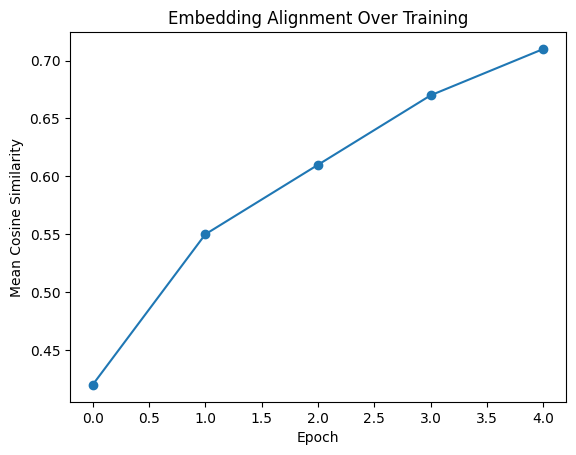

In [44]:
epoch_similarity = [0.42, 0.55, 0.61, 0.67, 0.71]   # example

plt.figure()
plt.plot(epoch_similarity, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Mean Cosine Similarity")
plt.title("Embedding Alignment Over Training")
plt.show()